In [1]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
# Load Libraries and set directories
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay,classification_report,roc_curve, auc
from sklearn.model_selection import cross_val_predict
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.preprocessing import OneHotEncoder

In [3]:
import sys
import os

sys.path.append(os.path.expanduser('~/Documents/Apziva_projects'))
import feature_plots as fp

In [5]:
!pwd

/Users/mikki/Documents/Apziva_projects/YyqSMCLaRZesyT0w


##Data Exploration

age : age of customer (numeric)

job : type of job (categorical)

marital : marital status (categorical)

education (categorical)

default: has credit in default? (binary)

balance: average yearly balance, in euros (numeric)

housing: has a housing loan? (binary)

loan: has personal loan? (binary)

contact: contact communication type (categorical)

day: last contact day of the month (numeric)

month: last contact month of year (categorical)

duration: last contact duration, in seconds (numeric)

campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

In [25]:
df = pd.read_csv("term-deposit-marketing-2020.csv")
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no


In [ ]:
df["default"] = df["default"].map({"yes": 1, "no": 0})
df["housing"] = df["housing"].map({"yes": 1, "no": 0})
df["loan"] = df["loan"].map({"yes": 1, "no": 0})
df["y"] = df["y"].map({"yes": 1, "no": 0})
df['month'] = df['month'].map({'jan':1, 'feb':2, 'mar':3, 'apr':4, 'may':5, 'jun':6, 'jul':7, 'aug':8, 'sep':9, 'oct':10, 'nov':11, 'dec':12})
df['age_log'] = np.log(df['age'] + 1)
df['duration_log'] = np.log(df['duration'] + 1)
df['job'] = np.where()

In [55]:
df.balance.describe()

count     40000.000000
mean       1274.277550
std        2903.769716
min       -8019.000000
25%          54.000000
50%         407.000000
75%        1319.000000
max      102127.000000
Name: balance, dtype: float64

In [29]:
bins = [-np.inf, 0, np.quantile(df['balance'], 0.25), np.quantile(df['balance'], 0.75), np.quantile(df['balance'], 0.90), np.inf]
labels = ['Neg', 'Low', 'Med', 'High','Very High']

df['balance_cat'] = pd.cut(df['balance'], bins=bins, labels=labels)

df['balance_cat'].value_counts()


balance_cat
Med          20000
Neg           6940
High          5995
Very High     4000
Low           3065
Name: count, dtype: int64

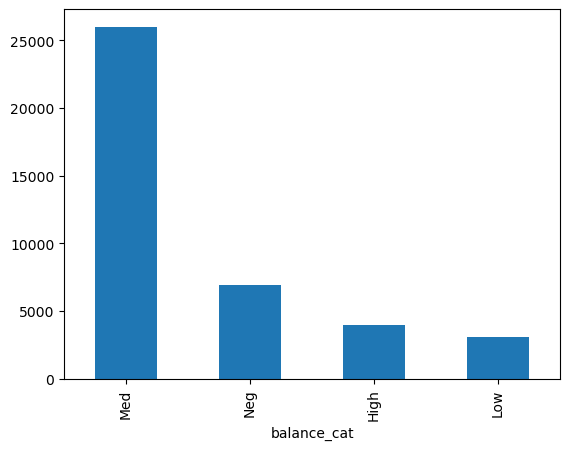

In [63]:
df['balance_cat'].value_counts().plot(kind='bar')
plt.show()  

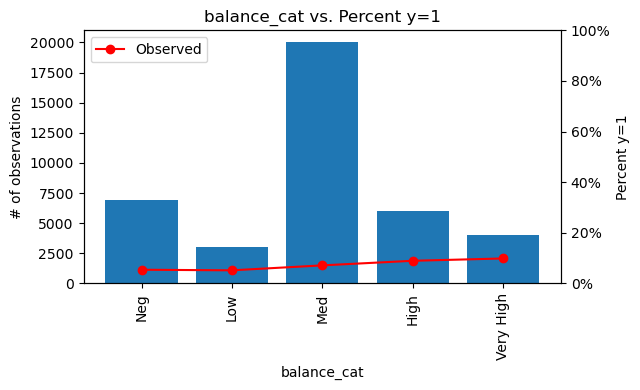

In [31]:
fp.plot_feature_vs_y(df, feature = 'balance_cat',y_col='y', dtype= 'cat', levels = ['Neg', 'Low', 'Med', 'High', 'Very High'], show_boxplot=False)

In [42]:
df[(df['age']> 65) & (df['y'] == 1)]


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y,age_log,balance_log,duration_log,balance_cat
29464,68,retired,divorced,primary,0,250,0,0,cellular,3,2,360,1,1,4.234107,5.525453,5.888878,Med
29865,75,retired,divorced,primary,0,3881,1,0,cellular,4,2,136,3,1,4.330733,8.264106,4.919981,Very High
29961,69,retired,married,primary,0,324,0,0,cellular,4,2,136,4,1,4.248495,5.783825,4.919981,Med
30176,69,management,married,tertiary,0,840,0,0,telephone,5,2,128,3,1,4.248495,6.734592,4.859812,Med
30627,66,technician,married,secondary,0,0,0,0,cellular,6,2,751,1,1,4.204693,0.000000,6.622736,Neg
30907,66,retired,married,primary,0,206,0,0,cellular,9,2,479,1,1,4.204693,5.332719,6.173786,Med
31032,69,retired,married,primary,0,2346,0,0,cellular,11,2,354,2,1,4.248495,7.760893,5.872118,High
31055,85,retired,married,primary,0,12114,0,0,telephone,12,2,165,2,1,4.454347,9.402200,5.111988,Very High
31057,72,retired,married,tertiary,0,0,0,0,cellular,13,2,99,1,1,4.290459,0.000000,4.605170,Neg
31069,90,retired,divorced,secondary,0,1,0,0,cellular,13,2,152,3,1,4.510860,0.693147,5.030438,Low


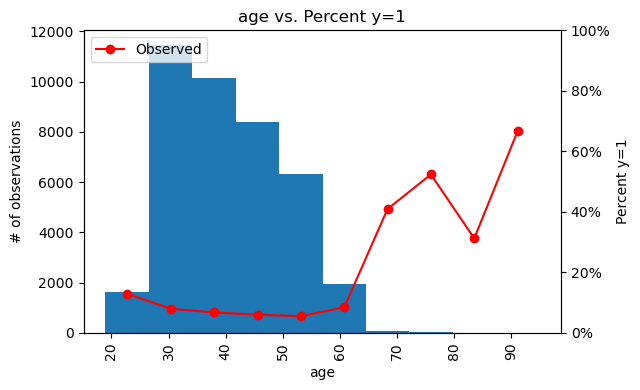

In [39]:
fp.plot_feature_vs_y(df, feature = 'age',y_col='y', dtype= 'quant', show_boxplot=False, n_bins= 10, bin_method="cut")

In [36]:
fp.summarize_features_quant(df, 'age', 'y', y_pred_col=None, bin_method="cut", n_bins=10)

(age
 (18.923, 26.6]     1612
 (26.6, 34.2]      11462
 (34.2, 41.8]      10133
 (41.8, 49.4]       8376
 (49.4, 57.0]       6321
 (57.0, 64.6]       1952
 (64.6, 72.2]         83
 (72.2, 79.8]         42
 (79.8, 87.4]         16
 (87.4, 95.0]          3
 Name: count, dtype: int64,
 age
 (18.923, 26.6]    0.129653
 (26.6, 34.2]      0.079829
 (34.2, 41.8]      0.067798
 (41.8, 49.4]      0.060411
 (49.4, 57.0]      0.055529
 (57.0, 64.6]      0.084529
 (64.6, 72.2]      0.409639
 (72.2, 79.8]      0.523810
 (79.8, 87.4]      0.312500
 (87.4, 95.0]      0.666667
 Name: y, dtype: float64,
 None,
 array([22.7615, 30.4   , 38.    , 45.6   , 53.2   , 60.8   , 68.4   ,
        76.    , 83.6   , 91.2   ]),
 array([7.677, 7.6  , 7.6  , 7.6  , 7.6  , 7.6  , 7.6  , 7.6  , 7.6  ,
        7.6  ]))

In [52]:
filt = df['balance'] <= 3000
check = df[filt]
check.y.value_counts()

y
no     32933
yes     2441
Name: count, dtype: int64

In [54]:
(2896-2441)/2896

0.15711325966850828

In [5]:
df.y.value_counts()

,count
y,
0,37104
1,2896


In [50]:
df.balance.describe()

count     40000.000000
mean       1274.277550
std        2903.769716
min       -8019.000000
25%          54.000000
50%         407.000000
75%        1319.000000
max      102127.000000
Name: balance, dtype: float64

In [ ]:
#Check to ensure the values make sense
#Remove outliers by variable instead of general sweep
#Only remove outliers in training data

In [17]:
df_noOutliers.y.value_counts()

,count
y,
0,26887


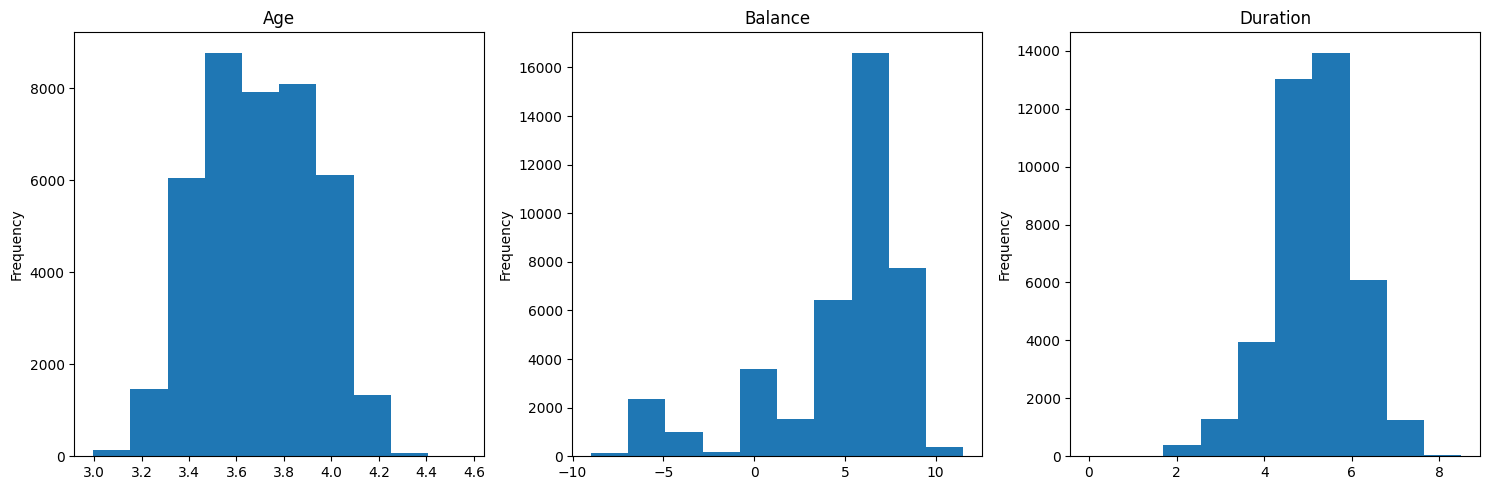

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
# Flatten axes for easy indexing
axes = axes.flatten()
df.age_log.plot.hist(ax=axes[0], title="Age")
df.balance_log.plot.hist(ax=axes[1], title="Balance")
df.duration_log.plot.hist(ax=axes[2], title="Duration")
plt.tight_layout()
plt.show()

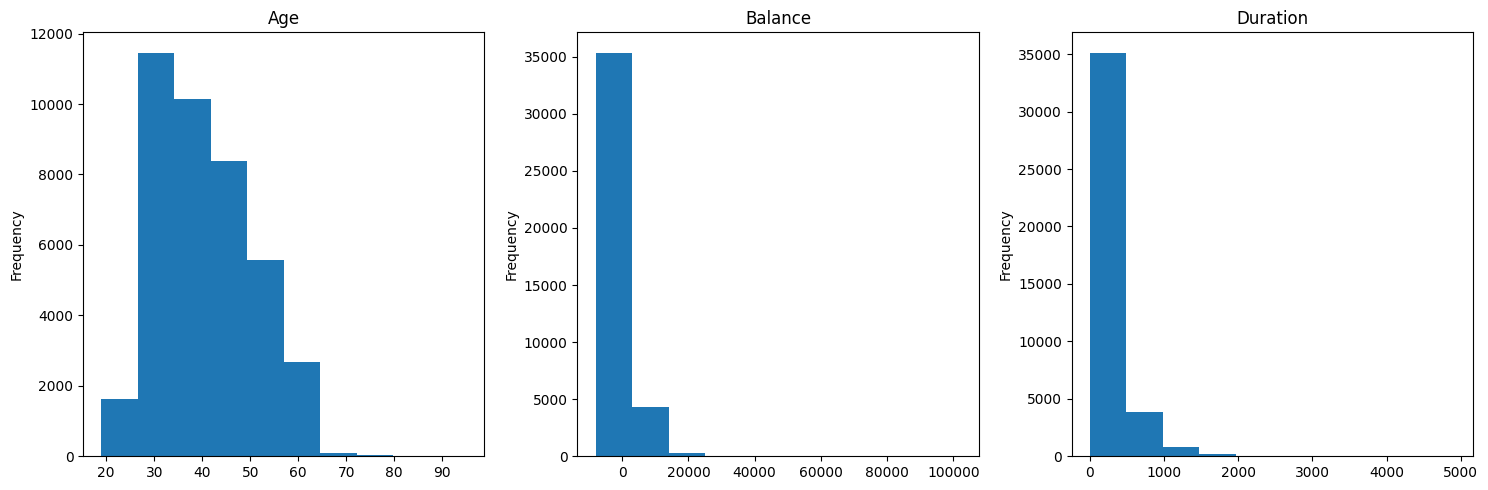

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
# Flatten axes for easy indexing
axes = axes.flatten()
df.age.plot.hist(ax=axes[0], title="Age")
df.balance.plot.hist(ax=axes[1], title="Balance")
df.duration.plot.hist(ax=axes[2], title="Duration")
plt.tight_layout()
plt.show()

In [ ]:
df.describe()

,age,default,balance,housing,loan,day,duration,campaign,y,age_log,balance_log,duration_log
count,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000
mean,40.544600,0.020225,1274.277550,0.600775,0.173250,16.017225,254.824300,2.882175,0.072400,3.700050,4.704834,5.148957
std,9.641776,0.140771,2903.769716,0.489745,0.378468,8.278127,259.366498,3.239051,0.259152,0.231429,3.921193,0.927780
min,19.000000,0.000000,-8019.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,2.995732,-8.989694,0.000000
25%,33.000000,0.000000,54.000000,0.000000,0.000000,8.000000,100.000000,1.000000,0.000000,3.526361,4.007333,4.615121
50%,39.000000,0.000000,407.000000,1.000000,0.000000,17.000000,175.000000,2.000000,0.000000,3.688879,6.011267,5.170484
75%,48.000000,0.000000,1319.000000,1.000000,0.000000,21.000000,313.000000,3.000000,0.000000,3.891820,7.185387,5.749393
max,95.000000,1.000000,102127.000000,1.000000,1.000000,31.000000,4918.000000,63.000000,1.000000,4.564348,11.533982,8.500861


In [ ]:
outliers = only_outliers_iqr(df)
outliers

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
2,33,entrepreneur,married,secondary,0,2,1,1,unknown,5,may,76,1,0
6,28,management,single,tertiary,0,447,1,1,unknown,5,may,217,1,0
7,42,entrepreneur,divorced,tertiary,1,2,1,0,unknown,5,may,380,1,0
20,28,blue-collar,married,secondary,0,723,1,1,unknown,5,may,262,1,0
22,32,blue-collar,single,primary,0,23,1,1,unknown,5,may,160,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39989,51,management,single,tertiary,0,102127,0,0,cellular,3,jun,90,1,0
39990,26,technician,single,secondary,0,1231,1,0,cellular,3,jun,385,2,1
39991,33,services,single,tertiary,0,1268,1,0,cellular,3,jun,2219,1,0
39996,30,management,single,tertiary,0,3340,0,0,cellular,3,jun,238,3,1


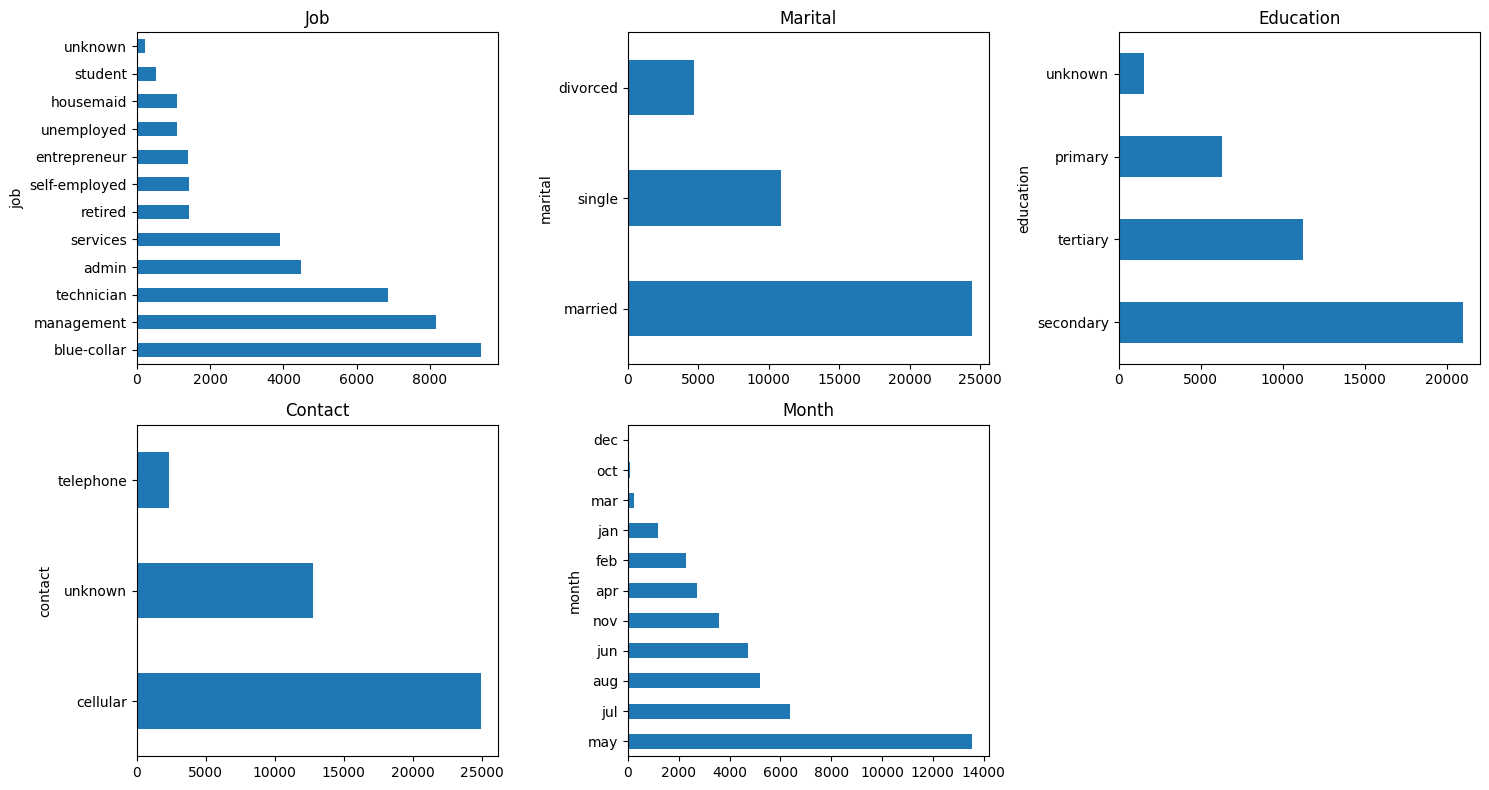

In [ ]:
# Make a grid of 2 rows × 3 columns
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))

# Flatten axes for easy indexing
axes = axes.flatten()

df.job.value_counts().plot.barh(ax=axes[0], title="Job")
df.marital.value_counts().plot.barh(ax=axes[1], title="Marital")
df.education.value_counts().plot.barh(ax=axes[2], title="Education")
df.contact.value_counts().plot.barh(ax=axes[3], title="Contact")
df.month.value_counts().plot.barh(ax=axes[4], title="Month")

# Hide the unused subplot (6th slot)
axes[5].axis("off")

plt.tight_layout()
plt.show()

###Explore Variable relationships with Y

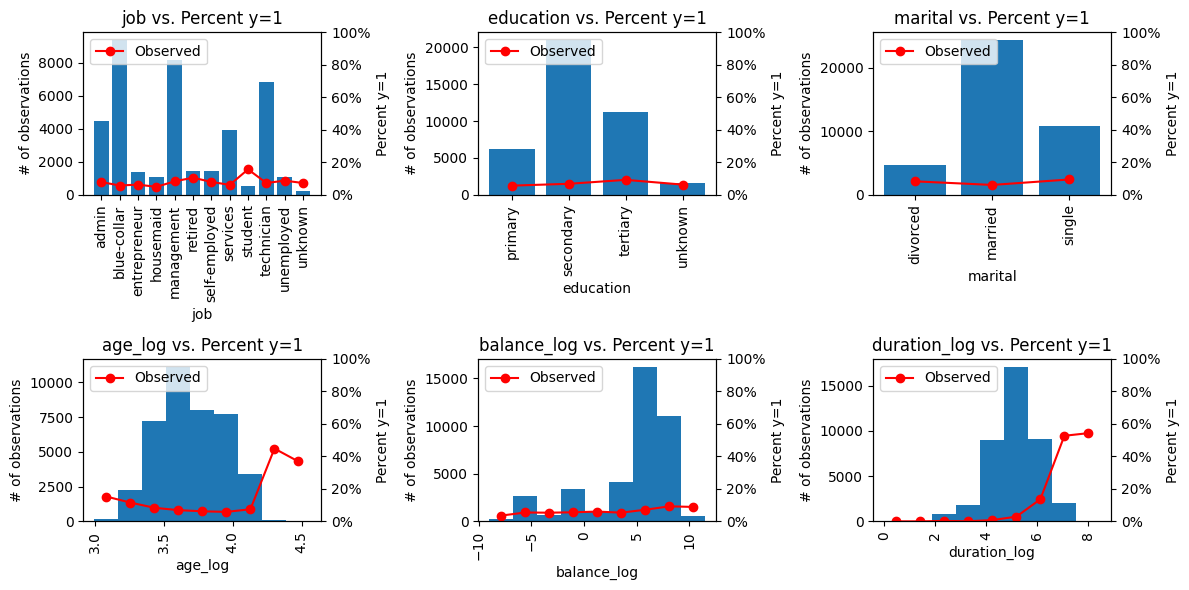

In [7]:
# Grid of many features
fp.plot_features_vs_y_grid(
    df, ["job","education","marital","age_log","balance_log","duration_log"],
    y_col="y",
    dtype={"job":"cat","education":"cat","marital":"cat","age_log":"quant","balance_log":"quant","duration_log":"quant"},
    n_bins=9, cols=3, bin_method = "cut"
)


##Model

**Data_split**

In [27]:
y = df["y"]
X = df.drop(columns=["y", "age", "balance", "duration"])
X.sample(15)

,job,marital,education,default,housing,loan,contact,day,month,campaign,age_log,balance_log,duration_log
23132,technician,single,secondary,0,0,0,cellular,26,8,3,3.433987,6.795706,3.828641
326,blue-collar,single,secondary,0,1,0,unknown,5,5,3,3.713572,6.079933,5.446737
30874,admin,married,secondary,0,1,0,cellular,9,2,5,3.970292,-6.137727,5.153292
34997,services,single,secondary,0,1,0,cellular,6,5,1,3.401197,4.382027,6.699500
17670,blue-collar,married,primary,0,1,1,cellular,29,7,10,3.951244,6.431331,4.488636
29644,unemployed,married,primary,0,1,0,cellular,3,2,3,4.007333,6.295266,5.472271
31065,management,single,tertiary,0,0,0,cellular,13,2,2,3.526361,8.175548,5.068904
9707,unknown,married,primary,0,0,0,unknown,6,6,2,3.970292,6.306275,3.526361
18557,services,married,secondary,0,1,1,cellular,31,7,5,4.007333,-6.440947,5.686975
21339,management,single,tertiary,0,0,0,telephone,18,8,2,4.025352,7.001246,5.298317


In [28]:
#Preprocessing Data
cat = ["job","education","marital","contact"]
#OneHot Encoding
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
ct = ColumnTransformer(
    [('one_hot', OneHotEncoder(dtype='float'), cat)],
    remainder='passthrough', verbose_feature_names_out=False)

X_hot_encode = ct.fit_transform(X)
hot_encode_names = ct.get_feature_names_out().tolist()
hot_encode_names

['job_admin',
 'job_blue-collar',
 'job_entrepreneur',
 'job_housemaid',
 'job_management',
 'job_retired',
 'job_self-employed',
 'job_services',
 'job_student',
 'job_technician',
 'job_unemployed',
 'job_unknown',
 'education_primary',
 'education_secondary',
 'education_tertiary',
 'education_unknown',
 'marital_divorced',
 'marital_married',
 'marital_single',
 'contact_cellular',
 'contact_telephone',
 'contact_unknown',
 'default',
 'housing',
 'loan',
 'day',
 'month',
 'campaign',
 'age_log',
 'balance_log',
 'duration_log']

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X_hot_encode, y, test_size=0.25)

In [35]:
X_test

array([[0.        , 0.        , 1.        , ..., 3.73766962, 5.72684775,
        4.63472899],
       [0.        , 0.        , 0.        , ..., 3.97029191, 8.07246737,
        4.35670883],
       [0.        , 0.        , 0.        , ..., 3.73766962, 8.29529886,
        5.75257264],
       ...,
       [0.        , 1.        , 0.        , ..., 3.40119738, 4.71849887,
        2.7080502 ],
       [0.        , 0.        , 0.        , ..., 4.11087386, 7.23777819,
        4.07753744],
       [0.        , 0.        , 0.        , ..., 3.78418963, 0.        ,
        4.82831374]])

In [30]:
# create model instance
bst = XGBClassifier(n_estimators=1000, max_depth=5, learning_rate=.1, objective='binary:logistic',scale_pos_weight = 2)
# fit model
bst.fit(X_train, y_train)
# make predictions
y_pred_train = bst.predict(X_train)
y_preds_test = bst.predict(X_test)

Train
Test


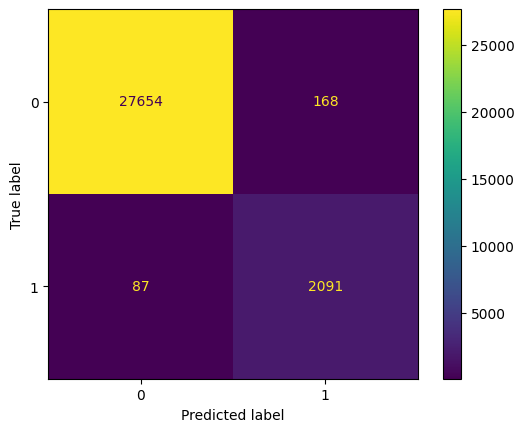

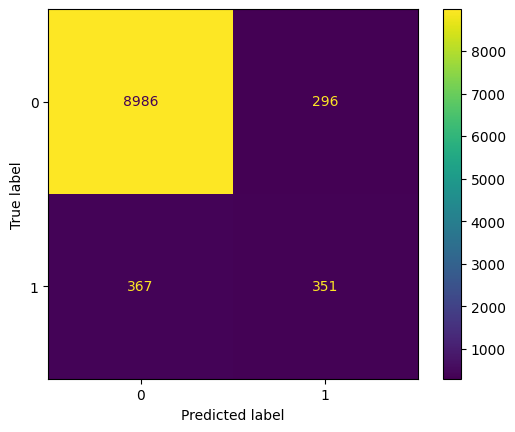

In [16]:
print("Train")
cm_train = confusion_matrix(y_train, y_pred_train, labels=bst.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=bst.classes_)
disp.plot()
print("Test")
cm_test = confusion_matrix(y_test, y_preds_test)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=bst.classes_)
disp_test.plot()
plt.show()

In [17]:
print("Train Metrics")
print(classification_report(y_train, y_pred_train))
print("Test Metrics")
print(classification_report(y_test, y_preds_test))

Train Metrics
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     27822
           1       0.93      0.96      0.94      2178

    accuracy                           0.99     30000
   macro avg       0.96      0.98      0.97     30000
weighted avg       0.99      0.99      0.99     30000

Test Metrics
              precision    recall  f1-score   support

           0       0.96      0.97      0.96      9282
           1       0.54      0.49      0.51       718

    accuracy                           0.93     10000
   macro avg       0.75      0.73      0.74     10000
weighted avg       0.93      0.93      0.93     10000



In [ ]:
model = joblib.load("your_saved.model")
model.get_booster().feature_names = ["your", "feature", "name", "list"]
xgboost.plot_importance(model.get_booster())

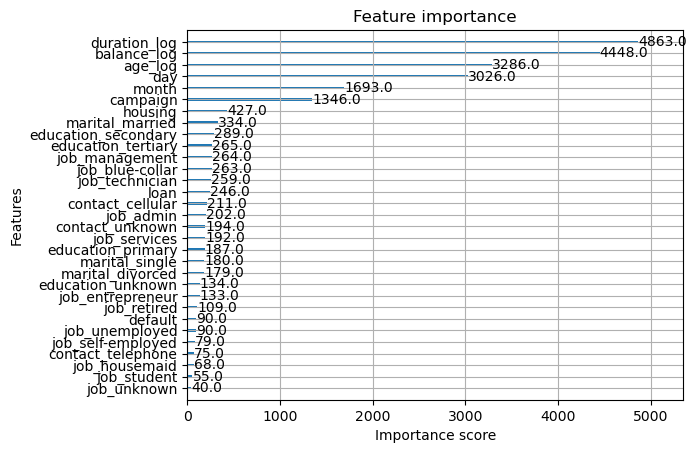

In [33]:
#AUC/ROC
#Predicted vs. Observed
bst.get_booster().feature_names = hot_encode_names
plot_importance(bst.get_booster())
plt.show()

In [40]:
X_test = pd.DataFrame(X_test, columns=hot_encode_names)

In [41]:
import shap
explainer = shap.Explainer(bst)
shap_values = explainer(X_test)
shap.initjs()

In [47]:
import matplotlib.pyplot as plt

shap.waterfall_plot(shap_values[0], show=False)  # create the plot, don't auto-display
plt.savefig("YyqSMCLaRZesyT0w/waterfall_plot.png", bbox_inches="tight", dpi=300)
plt.close()  # optional, so figures don’t pile up in memory


In [ ]:
n_bins = 8
AVG_bin = pd.qcut(df['AVG'], q=n_bins, duplicates='drop')

agg = (df
       .groupby(AVG_bin, observed=True)
       .agg(count=('y','size'), prop_y1=('y','mean'),
            x_mid=('AVG', 'median'))
       .reset_index())

# Plot
fig, (ax_left, ax_right) = plt.subplots(ncols=2, figsize=(10,4), gridspec_kw={'width_ratios':[2,1]})

# Left plot: counts + proportion
ax_left.bar(agg['x_mid'], agg['count'],
            width=np.diff(np.r_[agg['x_mid'], agg['x_mid'].iloc[-1]]).mean())
ax_left.set_xlabel('AVG (binned, midpoint)')
ax_left.set_ylabel('# of observations')

ax2 = ax_left.twinx()
ax2.plot(agg['x_mid'], agg['prop_y1'], marker='o', color='red')
ax2.set_ylabel('P(Y=1)')
ax2.set_ylim(0,1)
ax_left.set_title('P(Y=1) vs AVG (binned)')

# Right plot: boxplot
sns.boxplot(x='Y', y='AVG', data=df, ax=ax_right)
ax_right.set_title('Distribution of AVG by Y')

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
from matplotlib.ticker import PercentFormatter

def plot_feature_vs_happiness(df,feature,y_col="y", y_pred_col=None,
                              levels=(1, 2, 3, 4, 5),
                              show_boxplot=True,figsize=(10, 4)):
    from matplotlib.ticker import PercentFormatter
    # counts and means (fill missing categories with 0)
    counts = df[feature].value_counts().reindex(levels, fill_value=0)
    obs = df.groupby(feature)[y_col].mean().reindex(levels, fill_value=0.0)

    pred = None
    if y_pred_col and y_pred_col in df.columns:
        pred = df.groupby(feature)[y_pred_col].mean().reindex(levels, fill_value=0.0)

    # figure / axes
    if show_boxplot:
        fig, (ax_left, ax_right) = plt.subplots(ncols=2, figsize=figsize)
    else:
        fig, ax_left = plt.subplots(figsize=(figsize[0]*0.65, figsize[1]))
        ax_right = None

    # LEFT: bars + one twin axis for both lines
    ax_left.bar(counts.index, counts.values)
    ax_left.set_xlabel(feature)
    ax_left.set_ylabel('# of observations')
    ax_left.set_title(f'{feature} vs. customer satisfaction')

    ax_line = ax_left.twinx()
    ax_line.set_ylabel('Percent Happy')
    ax_line.set_ylim(0, 1)
    ax_line.yaxis.set_major_formatter(PercentFormatter(xmax=1.0))

    # plot observed (+ optional predicted) with a tiny loop
    handles = []
    for series, label, color in [(obs, 'Observed', 'red'), (pred, 'Predicted', 'yellow')]:
        if series is None:
            continue
        (ln,) = ax_line.plot(series.index, series.values, marker='o', label=label, color=color)
        handles.append(ln)

    if handles:
        ax_line.legend(handles=handles, loc='upper left')

    # RIGHT: optional boxplot
    if show_boxplot:
        sns.boxplot(x=y_col, y=feature, data=df, ax=ax_right)
        ax_right.set_title(f'Distribution of {feature} by {y_col}')
        ax_right.set_xlabel(f'{y_col} (0: Unhappy, 1: Happy)')

    plt.tight_layout()
    return fig, (ax_left, ax_right)
